In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import libpysal
# note that for pysal we need numpy<=2.0.0
from esda import Moran, Moran_Local
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import lines as mline

In [2]:
warnings.filterwarnings("ignore")

(4)  A species richness map is a spatial representation that shows the number of different species (i.e., species richness) present in specific geographic areas by counting the unique species observed within that area. It highlights the distribution of biodiversity across a landscape by depicting where higher or lower concentrations of species occur. 


Your task is to create a bird species richness map for Kenya. Your map should provide a clear visual representation of the geographic distribution of bird diversity and offer insights into potential biodiversity hotspots or areas of lower species richness. After doing so, analyze how bird species richness varies across the country.

In [3]:
def clean_dataframe(df:pd.DataFrame, drop_rate: float=0.5, verbose: bool = True) -> pd.DataFrame:
    if drop_rate < 0 or drop_rate > 1:
        raise ValueError('drop_rate must be between 0 and 1')
    shape = df.shape
    df = df[df.columns[df.isna().sum() / df.shape[0] <= drop_rate]]
    df = df[df.columns[df.nunique() != 1]]
    df.drop_duplicates(inplace=True)
    if verbose:
        print(f'Cleaned DataFrame shape: {df.shape}')
        print(f'{shape[0] - df.shape[0]} rows were dropped')
        print(f'{shape[1] - df.shape[1]} columns were dropped')
    return df

In [4]:
df_kenya_birds1_raw = pd.read_csv('./data/simple/simple.csv', sep='\t', dtype={'infraspecificEpithet': str})
# The last dtype is to avoid the warning: "DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False."
df_kenya_birds1 = clean_dataframe(df_kenya_birds1_raw)
print(df_kenya_birds1.columns)
df_kenya_birds1.head()

Cleaned DataFrame shape: (89632, 20)
0 rows were dropped
30 columns were dropped
Index(['gbifID', 'occurrenceID', 'order', 'family', 'genus', 'species',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'individualCount', 'decimalLatitude', 'decimalLongitude', 'eventDate',
       'day', 'month', 'year', 'taxonKey', 'speciesKey', 'lastInterpreted',
       'issue'],
      dtype='object')


,gbifID,occurrenceID,order,family,genus,species,taxonRank,scientificName,verbatimScientificName,individualCount,decimalLatitude,decimalLongitude,eventDate,day,month,year,taxonKey,speciesKey,lastInterpreted,issue
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.432285,38.341012,2017-11-09,9,11,2017,6100772,6100772.0,2024-03-21T12:54:52.894Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,Passeriformes,Zosteropidae,Zosterops,Zosterops senegalensis,SPECIES,"Zosterops senegalensis Bonaparte, 1850",Zosterops senegalensis,1.0,0.206000,34.884667,2017-06-01,1,6,2017,2489344,2489344.0,2024-03-21T12:54:54.972Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,Passeriformes,Zosteropidae,Zosterops,Zosterops senegalensis,SPECIES,"Zosterops senegalensis Bonaparte, 1850",Zosterops senegalensis,4.0,-0.558500,36.523667,2017-06-01,1,6,2017,2489344,2489344.0,2024-03-21T12:54:57.153Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.399601,38.329516,2017-10-06,6,10,2017,6100772,6100772.0,2024-03-21T12:55:11.136Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.380438,38.353286,2017-10-06,6,10,2017,6100772,6100772.0,2024-03-21T12:54:51.116Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...


In [5]:
df = df_kenya_birds1[['order', 'decimalLongitude', 'decimalLatitude', 'individualCount', 'species', 'scientificName']].copy()
print(df.isna().sum())
df[df['species'].isna() & df['scientificName'].notna()]

order                 0
decimalLongitude      0
decimalLatitude       0
individualCount      80
species             185
scientificName        0
dtype: int64


,order,decimalLongitude,decimalLatitude,individualCount,species,scientificName
37536,Piciformes,35.258667,0.507667,2.0,NaN,"Mesopicos Malherbe, 1849"
37541,Piciformes,36.608833,-0.791833,2.0,NaN,"Mesopicos Malherbe, 1849"
37544,Piciformes,34.853000,0.340500,1.0,NaN,"Mesopicos Malherbe, 1849"
37581,Piciformes,34.270833,0.554000,1.0,NaN,"Mesopicos Malherbe, 1849"
37738,Piciformes,37.000000,-0.450000,1.0,NaN,"Mesopicos Malherbe, 1849"
...,...,...,...,...,...,...
40299,Passeriformes,37.514885,0.251445,1.0,NaN,"Melaenornis G.R.Gray, 1840"
40305,Passeriformes,38.649600,-3.487681,1.0,NaN,"Melaenornis G.R.Gray, 1840"
40331,Passeriformes,37.385798,1.009533,1.0,NaN,"Melaenornis G.R.Gray, 1840"
75369,Passeriformes,35.402927,-1.520081,1.0,NaN,"Camaroptera Sundevall, 1850"


In [6]:
df.drop(columns=['species'], inplace=True)
df = df.dropna().reset_index(drop=True)
df['individualCount'] = df['individualCount'].astype('int')
df.head()

,order,decimalLongitude,decimalLatitude,individualCount,scientificName
0,Passeriformes,38.341012,-3.432285,1,"Zosterops silvanus J.L.Peters & Loveridge, 1935"
1,Passeriformes,34.884667,0.206000,1,"Zosterops senegalensis Bonaparte, 1850"
2,Passeriformes,36.523667,-0.558500,4,"Zosterops senegalensis Bonaparte, 1850"
3,Passeriformes,38.329516,-3.399601,1,"Zosterops silvanus J.L.Peters & Loveridge, 1935"
4,Passeriformes,38.353286,-3.380438,1,"Zosterops silvanus J.L.Peters & Loveridge, 1935"


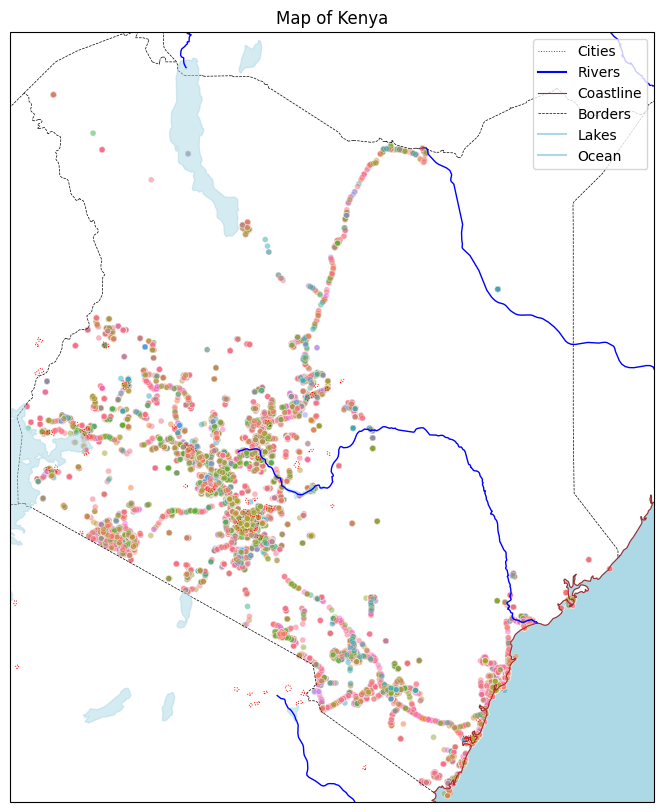

In [7]:
def draw_kenya(ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(
            subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10)
        )

    ax.set_extent([33.8, 42, -4.8, 5])  # [lon_min, lon_max, lat_min, lat_max]
    ax.add_feature(cfeature.COASTLINE, edgecolor="brown", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)
    ax.add_feature(cfeature.LAKES, color="lightblue", alpha=0.5)
    ax.add_feature(cfeature.RIVERS, edgecolor="blue")
    ax.add_feature(cfeature.OCEAN, color="lightblue")

    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "cultural",
            "urban_areas",
            "10m",
            edgecolor="red",
            facecolor="none",
            linewidth=0.7,
            linestyle=":",
        ),
        label="Cities",
    )

    # ax.legend(
    #     t := [
    #         mline.Line2D([], [], color=i.get_edgecolor(), linewidth=i.get_linewidth(), linestyle=i.get_linestyles()[0], label=i.get_label(), alpha=i.get_alpha())
    #         for i in [coastline, border, lakes, cities, river, ocean]
    #     ],
    #     [i.get_label() for i in [coastline, border, lakes, cities, river, ocean]],
    # )
    if legend:
        ax.legend(
            [
                mline.Line2D(
                    [], [], color="red", linestyle=":", linewidth=0.7, label="Cities"
                ),
                mline.Line2D([], [], color="blue", label="Rivers"),
                mline.Line2D([], [], color="brown", linewidth=0.8, label="Coastline"),
                mline.Line2D(
                    [],
                    [],
                    color="black",
                    linestyle="--",
                    linewidth=0.5,
                    label="Borders",
                ),
                mline.Line2D([], [], color="lightblue", label="Lakes"),
                mline.Line2D([], [], color="lightblue", label="Ocean"),
            ],
            ["Cities", "Rivers", "Coastline", "Borders", "Lakes", "Ocean"],
        )

    plt.title("Map of Kenya")
    return ax


ax = draw_kenya()
sns.scatterplot(
        data=df,
        x="decimalLongitude",
        y="decimalLatitude",
        hue="order",
        size="individualCount",
        # sizes=(10, 500),
        alpha=0.5,
        ax=ax,
        legend=False,
    )
plt.show()
